# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import requests
import os
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#read the file into notebook
df = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
#create the request
url =  'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
images = requests.get(url, auth =('user', 'pass'))

with open('image-predictions.tsv', mode='wb') as file:
    file.write(images.content)

df1 = pd.read_csv('image-predictions.tsv', sep='\t')

df1.to_csv('image_predictions.csv', index=False)


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
temp = [] 
with open('tweet_json.txt', encoding='utf-8') as js_file:
   for i in js_file:
        dat = json.loads(i)
        tweet_id = dat['id']
        retweet_count = dat['retweet_count'] 
        favorite_count = dat['favorite_count']
        #append to list of dictionaries
        temp.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
df2 = pd.DataFrame(temp, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

df2.to_csv('tweet.csv', index=False)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [5]:
#display 10 random samples of df table
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1876,675111688094527488,NaN,NaN,2015-12-11 00:35:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Oliver. He thought what was insid...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675111688...,8,10,Oliver,None,None,None,None
1891,674764817387900928,NaN,NaN,2015-12-10 01:37:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pups are masters of camouflage. Very...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674764817...,10,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
1398,699775878809702401,NaN,NaN,2016-02-17 02:02:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Fillup. Spaghetti is his main weakness. A...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699775878...,11,10,Fillup,None,None,None,None
725,782722598790725632,NaN,NaN,2016-10-02 23:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She fought a bee and the bee wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
2104,670668383499735048,NaN,NaN,2015-11-28 18:19:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a magical dog. Only appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670668383...,10,10,Phineas,None,None,None,None
1052,742528092657332225,NaN,NaN,2016-06-14 01:24:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maxaroni. He's pumped as hell for the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742528092...,10,10,Maxaroni,None,None,None,None
338,832369877331693569,NaN,NaN,2017-02-16 23:23:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He fell asleep on a heating v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832369877...,11,10,Charlie,None,None,None,None
919,756526248105566208,NaN,NaN,2016-07-22 16:28:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",All hail sky doggo. 13/10 would jump super hig...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756526248...,13,10,None,doggo,None,None,None


In [6]:
#Getting the tweets that are not retweets
option = ['NaN']
df_new1 = df.loc[df['in_reply_to_status_id'].isin(option)]


In [7]:
#Getting the tweets that are not retweets
option = ['NaN']
df_new2 = df_new1.loc[df['retweeted_status_id'].isin(option)]
df_new2.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1572,687664829264453632,NaN,NaN,2016-01-14 15:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Opal. He's a Belgian Dijon Poofster. Upse...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687664829...,11,10,Opal,None,None,None,None
1821,676582956622721024,NaN,NaN,2015-12-15 02:02:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Vinnie. He's having fun while being safe....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676582956...,8,10,Vinnie,None,None,None,None
721,783334639985389568,NaN,NaN,2016-10-04 15:55:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dave. He's currently in a predicament....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783334639...,12,10,Dave,None,None,None,None
1651,683498322573824003,NaN,NaN,2016-01-03 04:01:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Griffin. He's desperate for both a phy...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683498322...,11,10,Griffin,None,None,None,None
712,784431430411685888,NaN,NaN,2016-10-07 16:33:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stormy. He's curly af. Already pupared...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/784431430...,12,10,Stormy,None,None,None,None
1401,699434518667751424,NaN,NaN,2016-02-16 03:25:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I know this is a tad late but here's a wonderf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699434518...,12,10,None,None,None,pupper,None
1794,677328882937298944,NaN,NaN,2015-12-17 03:26:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. All the dogs adore Derek. He's ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677328882...,10,10,Derek,None,None,None,None
1542,689599056876867584,NaN,NaN,2016-01-20 00:03:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see 33 dogs posing for a picture. All ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689599056...,11,10,None,None,None,None,None
219,850145622816686080,NaN,NaN,2017-04-07 00:38:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Riley. He's making new friends. Jubila...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/850145622...,11,10,Riley,None,None,None,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,None,None,None


In [8]:
#delete unwanted columns
df_new2.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'source', 'expanded_urls'], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
df_new2.drop(columns=['retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


In [11]:
#display table 2
df1.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
# view info of df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
#delete unwanted columns
df1.drop(columns=['jpg_url','img_num'], inplace=True)

In [14]:
#display table 3
df2.head(10)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [16]:
#merge the tables together
df_a = pd.merge(df_new2, df1, on='tweet_id', how ='left')
df_all = pd.merge(df_a, df2, on = 'tweet_id', how ='left')

In [17]:
#view df_all
df_all.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048


In [18]:
# inspect the data by getting 5 random samples
df_all.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1552,677335745548390400,2015-12-17 03:53:20 +0000,Downright inspiring 12/10 https://t.co/vSLtYBWHcQ,12,10,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,3328
1219,696754882863349760,2016-02-08 17:58:03 +0000,This is Reptar. He specifically asked for his ...,10,10,Reptar,None,None,None,None,...,0.137832,False,toy_poodle,0.098378,True,Scottish_deerhound,0.097397,True,396,1615
1248,693642232151285760,2016-01-31 03:49:30 +0000,Meet Freddery. He's a Westminster Toblerone. S...,9,10,Freddery,None,None,None,None,...,0.111893,True,bluetick,0.074302,True,German_short-haired_pointer,0.067000,True,472,2790
872,737826014890496000,2016-06-01 02:00:04 +0000,This is Remy. He has some long ass ears (proba...,10,10,Remy,None,None,None,None,...,0.990391,True,Rhodesian_ridgeback,0.005605,True,Chesapeake_Bay_retriever,0.002869,True,2006,5757
116,866334964761202691,2017-05-21 16:48:45 +0000,This is Coco. At first I thought she was a clo...,12,10,Coco,None,None,None,None,...,0.984086,True,Pomeranian,0.007919,True,keeshond,0.003328,True,15546,54720


In [19]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 21 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-nul

In [20]:
#view the null data in the image prediction group
df_all.isnull().sum()

tweet_id                0
timestamp               0
text                    0
rating_numerator        0
rating_denominator      0
name                    0
doggo                   0
floofer                 0
pupper                  0
puppo                   0
p1                    126
p1_conf               126
p1_dog                126
p2                    126
p2_conf               126
p2_dog                126
p3                    126
p3_conf               126
p3_dog                126
retweet_count           0
favorite_count          0
dtype: int64

In [21]:
#count the number of times each name occurs 
df_all['name'].value_counts()

None            603
a                55
Lucy             11
Charlie          11
Cooper           10
Oliver           10
Tucker            9
Penny             9
Sadie             8
Lola              8
Winston           8
the               8
Daisy             7
Toby              7
Bailey            6
Stanley           6
Oscar             6
an                6
Jax               6
Bo                6
Koda              6
Bella             6
Dave              5
Scout             5
Louis             5
Bentley           5
Rusty             5
Chester           5
Buddy             5
Milo              5
               ... 
Maya              1
Bobbay            1
Randall           1
Shooter           1
Samsom            1
Beya              1
Happy             1
Mimosa            1
Covach            1
Staniel           1
Mollie            1
Chef              1
Jarvis            1
unacceptable      1
Gunner            1
Mutt              1
Gustav            1
Yukon             1
Lorelei           1


In [22]:
#check value_count for denominator_rating
df_all['rating_denominator'].value_counts()

10     2080
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [23]:
#Further investigate the rating denominator greater than 10
df_all[df_all['rating_denominator'] == 50]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
985,716439118184652801,2016-04-03 01:36:11 +0000,This is Bluebert. He just saw that both #Final...,50,50,Bluebert,None,None,None,None,...,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,247,2574
1056,709198395643068416,2016-03-14 02:04:08 +0000,"From left to right:\nCletus, Jerome, Alejandro...",45,50,None,None,None,None,None,...,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,721,2634
1129,704054845121142784,2016-02-28 21:25:30 +0000,Here is a whole flock of puppers. 60/50 I'll ...,60,50,a,None,None,None,None,...,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,1028,3201


Upon investigation, it was found out that for some of the dogs in which the denominator ratings are greater than 10, it is error in extracting the value and for others many dogs were rated at once. Therefore it is best to drop these rows. 

In [24]:
#check for duplicates in the df_all data
df_all.duplicated().sum()

0

### Quality issues
> The following quality issues have been discovered
 1. Denominator rating not consistent
 2. Timestamp is a DateTime object not a string
 3. Names are proper nouns, not articles or pronouns 
 4. Dog Stages mostly None
 5. Some images not dog images
 6. Inconsistent values for p2_conf and p3_conf
 7. Inconsistent values for p3_conf
 8. Some values in p1, p2, p3 in proper form, some in lower case
 9. Some null values in merged dataframe


### Tidiness issues
> The following tidiness issues have been discovered
1. One Variable in four columns(doggo, fluffer, pupper and puppo)
2. One Variable in two columns(rating_numerator, and rating_denominator)

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [25]:
# Make copies of original pieces of data
df_clean = df_all.copy()

### Quality Issues
#### Issue #1: Denominator rating not consistent

#### Define:
- Keep only rows where rating_denominator is equal to 10

#### Code

In [26]:
df_clean = df_clean[df_clean['rating_denominator'] == 10]

#### Test

In [27]:
df_clean['rating_denominator'].value_counts()

10    2080
Name: rating_denominator, dtype: int64

#### Issue #2: Timestamp is a DateTime object not a string

#### Define
- Convert Timestamp to DateTime using pd.to_datetime()

#### Code

In [28]:
df_clean['timestamp']= pd.to_datetime(df_clean['timestamp'])

#### Test

In [29]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2096
Data columns (total 21 columns):
tweet_id              2080 non-null int64
timestamp             2080 non-null datetime64[ns]
text                  2080 non-null object
rating_numerator      2080 non-null int64
rating_denominator    2080 non-null int64
name                  2080 non-null object
doggo                 2080 non-null object
floofer               2080 non-null object
pupper                2080 non-null object
puppo                 2080 non-null object
p1                    1954 non-null object
p1_conf               1954 non-null float64
p1_dog                1954 non-null object
p2                    1954 non-null object
p2_conf               1954 non-null float64
p2_dog                1954 non-null object
p3                    1954 non-null object
p3_conf               1954 non-null float64
p3_dog                1954 non-null object
retweet_count         2080 non-null int64
favorite_count        2080

#### Issue #3: Dog Names are proper nouns, and begin with a capital letter

#### Define
- filter for rows where names are not proper and keep only rows where names are proper, that is starts with a capital letter

#### Code

In [30]:
df_clean = df_clean[df_clean['name'].str.islower() == False]

#### Test

In [31]:
df_clean['name'].value_counts()

None         592
Lucy          11
Charlie       11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Lola           8
Winston        8
Sadie          8
Toby           7
Daisy          7
Oscar          6
Stanley        6
Bailey         6
Bella          6
Bo             6
Koda           6
Jax            6
Scout          5
Chester        5
Louis          5
Leo            5
Buddy          5
Dave           5
Milo           5
Bentley        5
Rusty          5
Maggie         4
Finn           4
            ... 
Mojo           1
Acro           1
Jamesy         1
Monty          1
Grady          1
Aiden          1
Jennifur       1
Dunkin         1
Carly          1
Mosby          1
Sojourner      1
Butters        1
Alfy           1
Buckley        1
Butter         1
Beya           1
Mimosa         1
Covach         1
Staniel        1
Mollie         1
Chef           1
Jarvis         1
Mutt           1
Gustav         1
Happy          1
Yukon          1
Jimbo          1
Enchilada     

#### Issue #4  Dog names mostly None


#### Define
- filter for rows where name != 'None'

#### Code

In [32]:
df_clean = df_clean[df_clean['name'] != "None"]

#### Test

In [33]:
df_clean.name.value_counts()

Lucy         11
Charlie      11
Oliver       10
Cooper       10
Penny         9
Tucker        9
Winston       8
Sadie         8
Lola          8
Toby          7
Daisy         7
Bo            6
Bailey        6
Koda          6
Stanley       6
Jax           6
Oscar         6
Bella         6
Leo           5
Buddy         5
Bentley       5
Scout         5
Dave          5
Milo          5
Louis         5
Chester       5
Rusty         5
Phil          4
Jerry         4
Clarence      4
             ..
Mojo          1
Acro          1
Jamesy        1
Monty         1
Grady         1
Aiden         1
Jennifur      1
Dunkin        1
Carly         1
Mosby         1
Sojourner     1
Butters       1
Alfy          1
Buckley       1
Butter        1
Beya          1
Mimosa        1
Covach        1
Staniel       1
Mollie        1
Chef          1
Jarvis        1
Mutt          1
Gustav        1
Happy         1
Yukon         1
Jimbo         1
Enchilada     1
Timison       1
Eugene        1
Name: name, Length: 927,

#### Issue #5: Some images not dog images

#### Define
- Keep rows where p1_dog,p2_dog,p3_dog == True

#### Code

In [34]:
df_clean = df_clean[(df_clean['p1_dog'] == True) & (df_clean['p2_dog'] == True) & (df_clean['p3_dog'] == True)]


#### Test

In [35]:
df_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,13,10,Zoey,None,None,None,None,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,4429,28226
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,None,None,None,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,7711,32467


In [36]:
#Drop p1_dog, p2_dog and p3_dog columns
df_clean = df_clean.drop(columns = ['p1_dog','p2_dog','p3_dog'])

#### Issue #6: Inconsistent values for p2_conf in terms of decimal placement

#### Define
- Round up p2_conf to 3.dp

#### Code

In [37]:
 df_clean['p2_conf'] = df_clean['p2_conf'].round(decimals=3)

#### Test

In [38]:
df_clean['p2_conf'].head()

1    0.091
2    0.078
4    0.226
8    0.193
9    0.451
Name: p2_conf, dtype: float64

#### Issue #7: Inconsitent values for p3_conf in terms of decimal placement

#### Define
- Round up p3_conf to 3.dp


#### Code

In [39]:
 df_clean['p3_conf'] = df_clean['p3_conf'].round(decimals=3)

#### Test

In [40]:
df_clean['p3_conf'].head()

1    0.069
2    0.031
4    0.175
8    0.118
9    0.029
Name: p3_conf, dtype: float64

#### Issue #8: Some values in p1, p2, p3 in proper form, some in lower case

#### Define
- Capitalize all p1,p2,p3 rows


#### Code

In [41]:

df_clean['p1'] = df_clean['p1'].str.capitalize()
df_clean['p2'] = df_clean['p2'].str.capitalize()
df_clean['p3'] = df_clean['p3'].str.capitalize()

#### Test

In [42]:

df_clean.head(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,p1,p1_conf,p2,p2_conf,p3,p3_conf,retweet_count,favorite_count
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,Chihuahua,0.323581,Pekinese,0.091,Papillon,0.069,6514,33819
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,Chihuahua,0.716012,Malamute,0.078,Kelpie,0.031,4328,25461
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,Basset,0.555712,English_springer,0.226,German_short-haired_pointer,0.175,9774,41048


#### Issue #9: Some null values in merged dataframe

#### Define
- Remove null values using the dropna() function

#### Code

In [43]:
df_clean.dropna(inplace=True)

#### Test

In [44]:
df_clean.isna().sum()

tweet_id              0
timestamp             0
text                  0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
p1                    0
p1_conf               0
p2                    0
p2_conf               0
p3                    0
p3_conf               0
retweet_count         0
favorite_count        0
dtype: int64

#### Issue #10 tweet_id is a string not an int

#### Define
- Convert tweet_id to a string object using astype()

#### Code


In [45]:
df_clean['tweet_id'] = df_clean['tweet_id'].astype(str)

#### Test

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 2066
Data columns (total 18 columns):
tweet_id              850 non-null object
timestamp             850 non-null datetime64[ns]
text                  850 non-null object
rating_numerator      850 non-null int64
rating_denominator    850 non-null int64
name                  850 non-null object
doggo                 850 non-null object
floofer               850 non-null object
pupper                850 non-null object
puppo                 850 non-null object
p1                    850 non-null object
p1_conf               850 non-null float64
p2                    850 non-null object
p2_conf               850 non-null float64
p3                    850 non-null object
p3_conf               850 non-null float64
retweet_count         850 non-null int64
favorite_count        850 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(10)
memory usage: 126.2+ KB


### Tidiness Issues

#### Issue #1:  Some column headers are values not variable names

#### Define
- Create a new variable : dog_stage and fill it with the data in the columns: doggo, fluffer, pupper and puppo, then drop the former columns

#### Code

In [47]:
df_clean1 = pd.melt(df_clean, id_vars=['tweet_id','timestamp','text','rating_numerator','rating_denominator', 'name','p1','p1_conf','p2','p2_conf','p3','p3_conf','retweet_count','favorite_count'], value_vars=['doggo','fluffer','pupper','puppo'], 
                   var_name='stages', value_name ='dog_stages').drop('stages',1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


#### Test

In [48]:
df_clean1.head(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,p1,p1_conf,p2,p2_conf,p3,p3_conf,retweet_count,favorite_count,dog_stages
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,Chihuahua,0.323581,Pekinese,0.091,Papillon,0.069,6514,33819,None
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,Chihuahua,0.716012,Malamute,0.078,Kelpie,0.031,4328,25461,None


#### Issue #2: A column header not named appropriately

#### Define
- Rename the rating numerator to rating and delete the rating denominator sice it now has a constant value of 10

#### Code

In [49]:
df_clean1.rename(columns = {'rating_numerator':'rating'}, inplace=True)
df_clean1.drop(columns = ['rating_denominator'], inplace=True)

#### Test

In [50]:
list(df_clean1.columns)

['tweet_id',
 'timestamp',
 'text',
 'rating',
 'name',
 'p1',
 'p1_conf',
 'p2',
 'p2_conf',
 'p3',
 'p3_conf',
 'retweet_count',
 'favorite_count',
 'dog_stages']

In [51]:
#Rearrange df_clean1 columns
df_clean1= df_clean1[['tweet_id','timestamp','text','name','dog_stages','rating','favorite_count','retweet_count', 'p1','p1_conf',
                     'p2','p2_conf','p3','p3_conf']]

In [52]:
#view rearranged data
df_clean1.head(1)


,tweet_id,timestamp,text,name,dog_stages,rating,favorite_count,retweet_count,p1,p1_conf,p2,p2_conf,p3,p3_conf
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,13,33819,6514,Chihuahua,0.323581,Pekinese,0.091,Papillon,0.069


In [53]:
#check for duplicates in the df_clean1 data
df_clean1.duplicated().sum()

1590

In [54]:
#remove duplicates
df_clean1.drop_duplicates(keep='first', inplace=True)

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [55]:
#save the df_clean1 for future use
df_clean1.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [56]:
df_clean1.describe()

,rating,favorite_count,retweet_count,p1_conf,p2_conf,p3_conf
count,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000
mean,11.037017,10019.169613,2875.163536,0.633978,0.141006,0.060744
std,1.742792,12645.222891,4373.803292,0.257719,0.103841,0.053102
min,2.000000,107.000000,23.000000,0.044333,0.000000,0.000000
25%,10.000000,2594.000000,759.000000,0.426459,0.053000,0.013000
50%,11.000000,5610.000000,1626.000000,0.652788,0.130000,0.048000
75%,12.000000,13167.250000,3438.250000,0.874419,0.207000,0.095000
max,27.000000,107956.000000,56625.000000,0.999837,0.468000,0.271000


In [57]:
#remove duplicates
df_clean.drop_duplicates(keep='first', inplace=True)

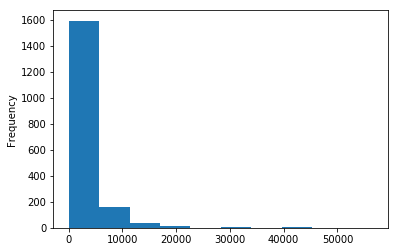

In [58]:
df_clean1['retweet_count'].plot.hist()

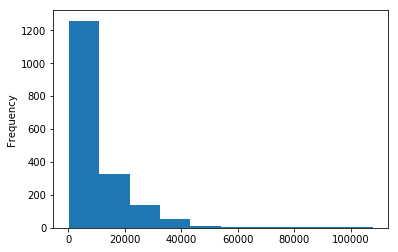

In [59]:
df_clean1['favorite_count'].plot.hist()

#### Questions
- Is there any correlation betwen a particular breed of dog and favorite_count or retweet_count?
- Is there any Correlation between rating and favorite_count or retweet_count?
- How does retweet_count relate to favorite_count

In [83]:
# Group by p1 which has the highest confidence rate in identifying the type of dog, then find the mean of favorite_count and retweet_count
dog_type_corr = df_clean1.groupby('p1', as_index=False)['favorite_count','retweet_count'].mean()
dog_type_corr.sort_values(['favorite_count'], ascending = [False])

,p1,favorite_count,retweet_count
92,Standard_poodle,33328.222222,14465.333333
81,Saluki,27624.333333,5841.333333
34,English_springer,26490.888889,10925.666667
50,Irish_water_spaniel,25225.000000,6039.000000
37,French_bulldog,22573.027027,6162.459459
18,Briard,18630.000000,6470.000000
7,Bedlington_terrier,18189.600000,3811.600000
22,Cardigan,17446.913043,5613.173913
40,Giant_schnauzer,17314.500000,5161.500000
13,Border_terrier,15530.833333,3853.000000


In [84]:
#group by rating, then find the avearge favorite and retweet count for each rating. 
dog_rating = df_clean1.groupby('rating')['favorite_count','retweet_count'].mean()
dog_rating.sort_values(['favorite_count'], ascending=[False])

,favorite_count,retweet_count
rating,,
14,34390.923077,12023.961538
13,23839.651246,6512.508897
5,12879.500000,3030.750000
12,12147.089770,3221.223382
27,7320.000000,1885.000000
3,7078.000000,1893.000000
11,6640.176179,2079.722084
2,5916.000000,2880.000000
10,3644.542373,1233.531073


### Insights:
1. Dogs with droppy ears(english springer, saluki, irish water spaniel, standard poodle, briard) have higher number of average retweet and favorite count. This is likely due to their peculiar cuteness and droppy ears.

2. Favorite count and retweet count are less likely determined by the dog rating. Investigations showed that the most liked and retweeted dogs didn't have the highest rating.

3. There is a high correlation between favorite_count and retweet_count, this means that a tweet that is highly liked is more likely to be highly retweeted

### Visualization

Text(0,0.5,'Dog Type')

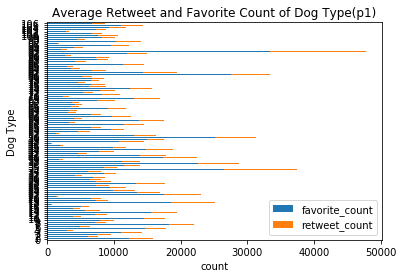

In [72]:
#visualise dog_rating
dog_type_corr.plot.barh(stacked=True)
plt.title('Average Retweet and Favorite Count of Dog Type(p1)')
plt.xlabel('count')
plt.ylabel('Dog Type')

Text(0,0.5,'Count')

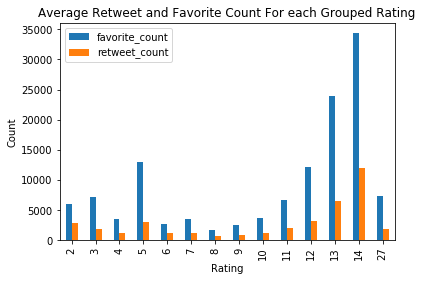

In [78]:
#visualise dog_type_corr
dog_rating.plot.bar()
plt.title('Average Retweet and Favorite Count For each Grouped Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0,0.5,'Retweet_count')

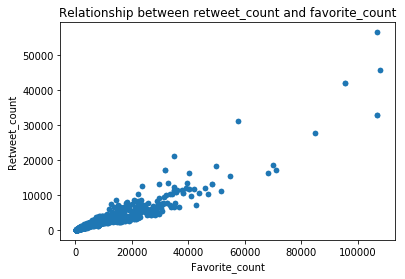

In [96]:
# Relationship between favorite_count and retweet_count
df_clean1.plot.scatter(x='favorite_count', y='retweet_count')
plt.title('Relationship between retweet_count and favorite_count')
plt.xlabel('Favorite_count')
plt.ylabel('Retweet_count')